In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#os.environ['R_HOME'] = "C:\\Program Files\\R\\R-4.3.1"

import sys
sys.path.append('..') # Add one directory back to the path

from process_coelution import coelution
import rpy2
from rpy2.robjects.packages import importr
#from rpy2.robjects import pandas2ri as p2r
#p2r.activate()
brms = importr('brms')
base = importr('base')
%load_ext rpy2.ipython

# Prep all PCB combinations

In [3]:
coelution_df = pd.read_csv('../data/full list of coelutions.csv')
coelution_list = []
for idx, row in coelution_df.iterrows():
    conj = row.dropna().astype(int)
    store_conj = ['PCB'+str(x) for x in conj]
    coelution_list.append(store_conj)
# Print first 5 pairs
print(coelution_list[:5])

[['PCB16', 'PCB32'], ['PCB56', 'PCB60'], ['PCB28', 'PCB31'], ['PCB5', 'PCB8'], ['PCB12', 'PCB13']]


# Run a single coelution

In [7]:
model_type = 'sample_only'
sample_sig = pd.read_csv(f'../scripts/model_selection_{model_type}.csv', index_col=0)#.astype(int)
sample_sig = sample_sig[sample_sig[model_type] == '1']
sample_sig#.sum()

,sample_only
PCB17_PCB18,1
PCB49_PCB52,1


In [8]:
%%time
#PCBs = ['PCB141', 'PCB153']
#PCBs = ['PCB180', 'PCB193']
#PCBs = ['PCB90', 'PCB101']
#PCBs = ['PCB124', 'PCB135', 'PCB144']
#PCBs = ['PCB124', 'PCB135', 'PCB144']
#PCBs = ['PCB135', 'PCB144', 'PCB151']
#PCBs = ['PCB16', 'PCB32']

PCBs = ['PCB17', 'PCB18']
#PCBs = ['PCB49', 'PCB52']
#PCBs = ['PCB194', 'PCB205']

#PCBs = ['PCB97', 'PCB110']
#PCBs = ['PCB16', 'PCB32']

#PCBs = ['PCB44', 'PCB47']
#PCBs = ['PCB16', 'PCB26', 'PCB32']
PCB_test = coelution(PCBs, model_type='sample_only', randomize_y=False)
PCB_test.prep_data()#handle_zeros='drop_ND')
PCB_test.fit_coelution(disp_summary=True)
PCB_test.sample_posterior()

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: 
Attaching package: ‘tidyr’


R[write to console]: The following object is masked from ‘package:rstan’:

    extract




 Family: dirichlet 
  Links: muPCB18 = logit; phi = log 
Formula: bind(PCB17, PCB18) ~ sample_type + (sample_type | HERO_ID) 
         phi ~ sample_type + (sample_type | HERO_ID)
   Data: df (Number of observations: 576) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Multilevel Hyperparameters:
~HERO_ID (Number of levels: 53) 
                                                  Estimate Est.Error l-95% CI
sd(muPCB18_Intercept)                                 0.17      0.13     0.01
sd(muPCB18_sample_typeoutdoor)                        0.31      0.12     0.05
sd(phi_Intercept)                                     1.39      0.21     0.98
sd(phi_sample_typeoutdoor)                            0.35      0.24     0.02
cor(muPCB18_Intercept,muPCB18_sample_typeoutdoor)     0.09      0.52    -0.87
cor(phi_Intercept,phi_sample_typeoutdoor)             0.31      0.47    -0.76
                                                  u-95% CI Rhat

In [10]:
print(PCB_test.R_str)


        library(brms)
        library(tidybayes)
        library(dplyr)
        library(tidyr)
        bind <- function(...) cbind(...)
        
        run_brms <- function(df, comp) {
            formula <- bf(bind(PCB17, PCB18) ~ sample_type + (sample_type|HERO_ID), phi ~ sample_type+ (sample_type|HERO_ID))
            priors <- c(set_prior('normal(0, 0.5)', class = 'sd', dpar='phi', lb=0), set_prior('normal(0, 3)', class = 'b', dpar='phi'), set_prior('normal(0, 3)', class = 'b', dpar='muPCB18'))
            mod <- brm(
                formula,
                family = dirichlet(refcat='PCB17'),
                data = df, backend='cmdstanr', prior = priors,
                chains=4, cores=4, iter = 2000, control = list(adapt_delta = 0.99), file = "../brms_models/sample_only/model_PCB17_PCB18"
                
            )
            if (comp == T){
                mod <- add_criterion(mod, 'loo')
            }
            return(mod)
        }
        
        
        sample_ppc

In [9]:
PCB_test.prop_summary

,sample_type,PCB,mean,sd,hdi_2.5%,hdi_97.5%,phi,N_sites,N_studies,raw_ND_count,raw_perc_ND,fitted_ND_count,fitted_perc_ND,coelution
0,indoor,PCB17,0.258,0.076,0.112,0.410,3.707,89,4,57,9.178744,57,9.178744,17+18
1,indoor,PCB18,0.742,0.076,0.590,0.888,3.707,89,4,57,9.178744,57,9.178744,17+18
2,outdoor,PCB17,0.324,0.079,0.176,0.486,3.585,1195,51,57,9.178744,57,9.178744,17+18
3,outdoor,PCB18,0.676,0.079,0.514,0.824,3.585,1195,51,57,9.178744,57,9.178744,17+18


In [24]:
PCB_test.check_diagnostics() # Single value included

/data/tzurlind/Desktop/PKWG/coelution/notebooks/../process_coelution.py:415: UserWarning: Warning: Divergences present (121)
  warnings.warn(f"Warning: Divergences present ({n_div})", UserWarning)


/data/tzurlind/Desktop/PKWG/manuscript_code/pcb-coelutions-air/notebooks/../process_coelution.py:798: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  grp2 = data_groupby.get_group(test)
/data/tzurlind/Desktop/PKWG/manuscript_code/pcb-coelutions-air/notebooks/../process_coelution.py:798: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  grp2 = data_groupby.get_group(test)
/data/tzurlind/pkgs/miniforge3/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 5.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/data/tzurlind/pkgs/miniforge3/lib/python3.12/site-packages/seaborn/categorical.py:339

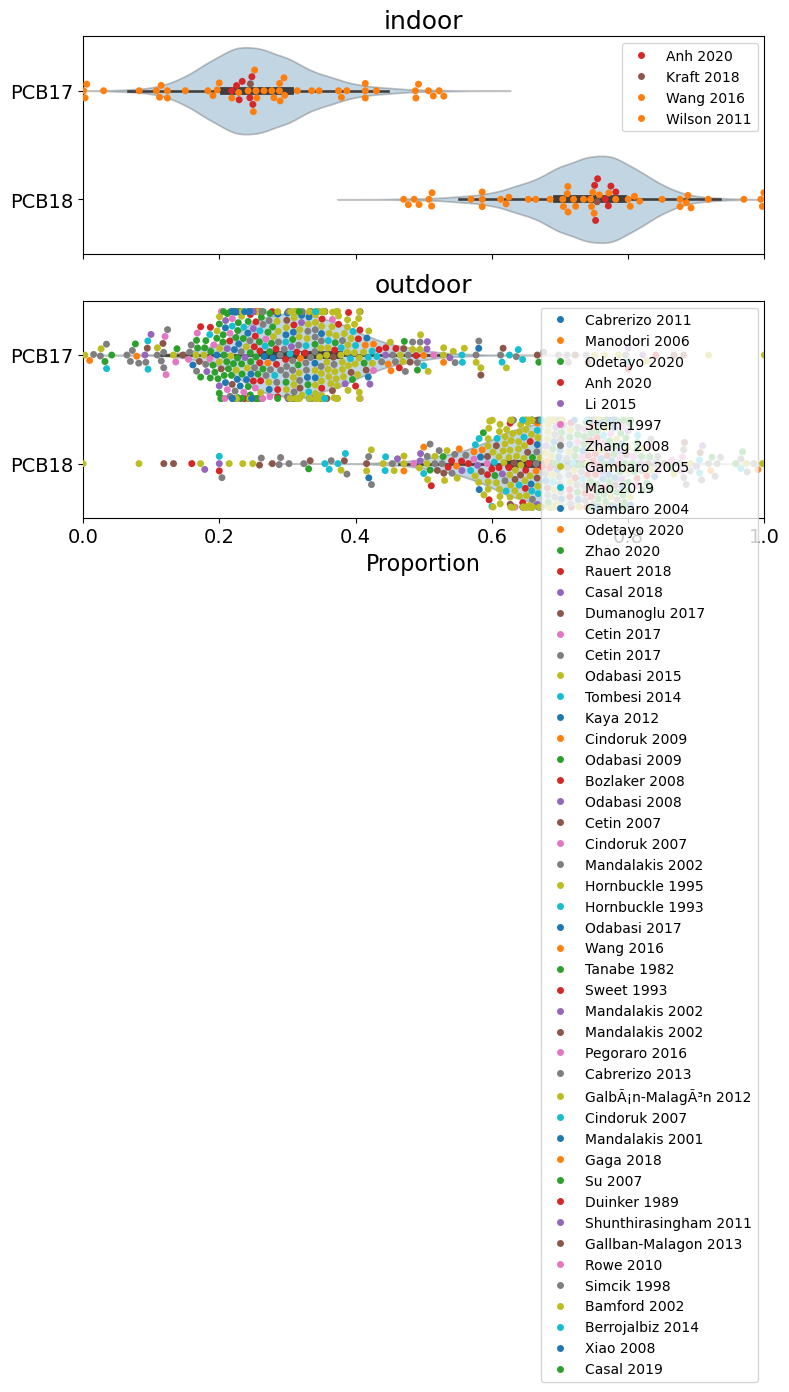

In [11]:
PCB_test.plot_comparison(observed='indiv')

/data/tzurlind/Desktop/PKWG/manuscript_code/pcb-coelutions-air/notebooks/../process_coelution.py:798: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  grp2 = data_groupby.get_group(test)
/data/tzurlind/Desktop/PKWG/manuscript_code/pcb-coelutions-air/notebooks/../process_coelution.py:798: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  grp2 = data_groupby.get_group(test)


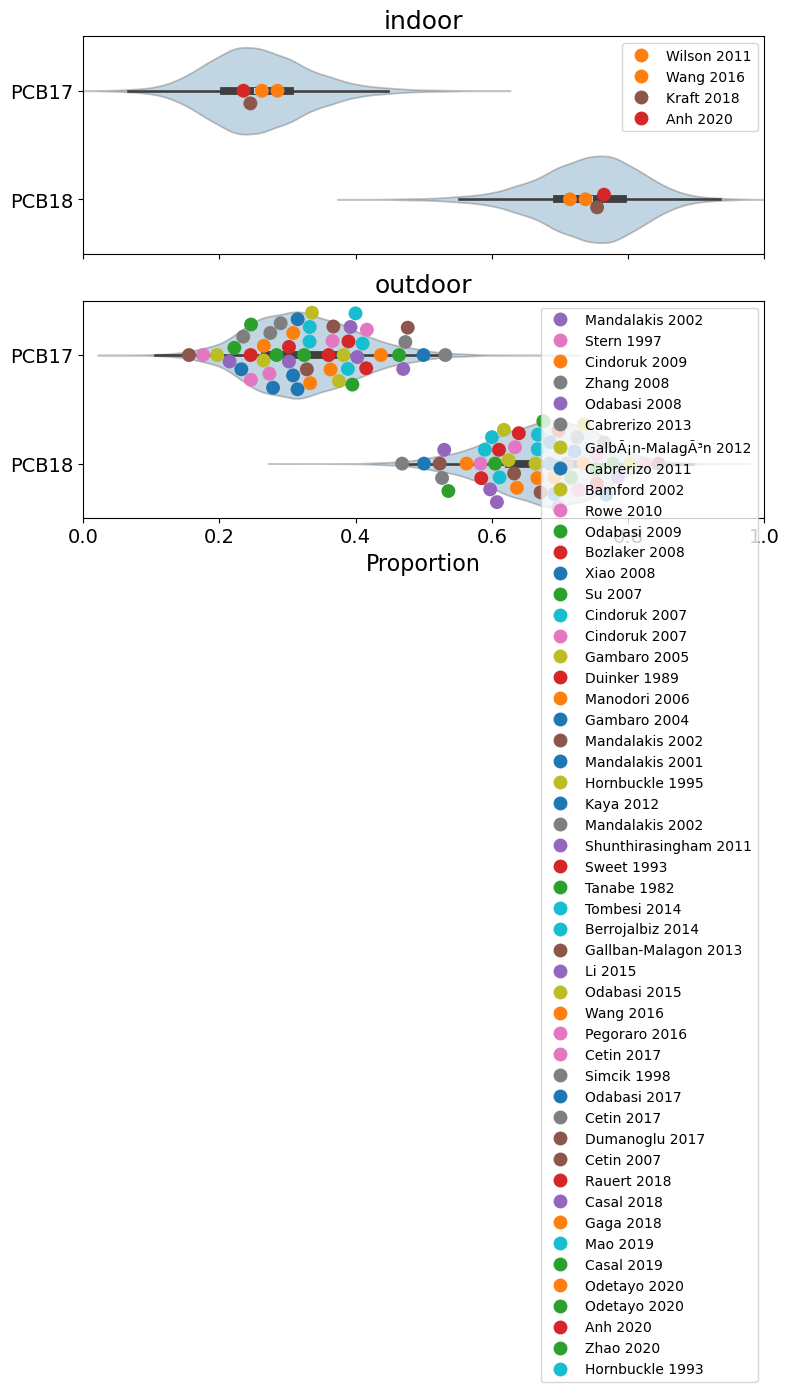

In [12]:
PCB_test.plot_comparison(observed='study')